In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import hashlib
import os

import lxml.etree
import tqdm
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [ ]:
!unzip /content/drive/My\ Drive/ML/faceMaskDataset/dataset.zip 

Archive:  /content/drive/My Drive/ML/faceMaskDataset/dataset.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
 

In [ ]:
!cp /content/drive/My\ Drive/ML/Weights/yolov3.weights .

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O ./yolov3.weights

--2020-07-27 14:53:38--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘./yolov3.weights’

./yolov3.weights    100%[===================>] 236.52M   210KB/s    in 13m 31s 

2020-07-27 15:07:11 (299 KB/s) - ‘./yolov3.weights’ saved [248007048/248007048]



In [ ]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]


def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            print("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()


def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
                 (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
                 (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)


def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis=-1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0:2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, class_names[classes[i]],
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          1, (0, 0, 255), 2)
    return img


def freeze_all(model, frozen=True):
    
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            
            freeze_all(l, frozen)


In [ ]:

# flags.DEFINE_integer('yolo_max_boxes', 100, 'maximum number of boxes per image')
# flags.DEFINE_float('yolo_iou_threshold', 0.5, 'iou threshold')
# flags.DEFINE_float('yolo_score_threshold', 0.5, 'score threshold')
yolo_max_boxes = 150
yolo_iou_threshold = 0.5
yolo_score_threshold = 0.5

yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)


def DarknetTiny(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 16, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 32, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 64, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 128, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = x_8 = DarknetConv(x, 256, 3)  # skip connection
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 512, 3)
    x = MaxPool2D(2, 1, 'same')(x)
    x = DarknetConv(x, 1024, 3)
    return tf.keras.Model(inputs, (x_8, x), name=name)


def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)

    return yolo_conv


# def YoloConvTiny(filters, name=None):
#     def yolo_conv(x_in):
#         if isinstance(x_in, tuple):
#             inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
#             x, x_skip = inputs
#
#             # concat with skip connection
#             x = DarknetConv(x, filters, 1)
#             x = UpSampling2D(2)(x)
#             x = Concatenate()([x, x_skip])
#         else:
#             x = inputs = Input(x_in.shape[1:])
#             x = DarknetConv(x, filters, 1)
#         return Model(inputs, x, name=name)(x_in)
#
#     return yolo_conv


def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)

    return yolo_output


def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=0.5,
        score_threshold=0.5
    )
    return boxes, scores, classes, valid_detections


def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, outputs, name='yolov3')


def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss

    return yolo_loss


In [ ]:

def load():
    yolo = YoloV3(classes=80)
    yolo.summary()
    print('model created')
    load_darknet_weights(yolo, './yolov3.weights')
    print('weights loaded')
    img = np.random.random((1, 320, 320, 3)).astype(np.float32)
    output = yolo(img)
    print('sanity check passed')
    yolo.save_weights('./checkpoints/yolov3.tf')
    print('weights saved')


load()


Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

In [ ]:
# from absl import app, flags, logging
# from absl.flags import FLAGS

# flags.DEFINE_string('data_dir', './input/face-mask-detection/',
#                     'path to raw dataset')
# flags.DEFINE_enum('split', 'train', [
#     'train', 'val'], 'specify train or val spit')
# flags.DEFINE_string('output_file', './data/mask_detection.tfrecord', 'output dataset')
# flags.DEFINE_string('classes', './input/classnames/faceMasks.names', 'classes file')
data_dir = './'
train_output_file = './maskdetection.tfrecord'
valid_output_file = './maskdetection_val.tfrecord'
classes = './faceMask.names'



def build_example(annotation, class_map):
    img_path = os.path.join(data_dir,'images', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()

    width = int(annotation['size']['width'])
    height = int(annotation['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}


def create_train():
    class_map = {name: idx for idx, name in enumerate(open(classes).read().splitlines())}
    print("Class mapping loaded: ", class_map)

    writer = tf.io.TFRecordWriter(train_output_file)
    image_list = os.listdir(os.path.join(data_dir, 'images'))
#     image_list = open(os.path.join(
#         FLAGS.data_dir, 'aeroplane_%s.txt' % FLAGS.split)).read().splitlines()
    print(f"Image list loaded: {len(image_list)}")
    for image in tqdm.tqdm(image_list[0: 700]):
        name, _ = image.split('.')
        annotation_xml = os.path.join(data_dir, 'annotations', name + '.xml')
        annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
        annotation = parse_xml(annotation_xml)['annotation']
        tf_example = build_example(annotation, class_map)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print("Done")
    
    
def create_valid():
    class_map = {name: idx for idx, name in enumerate(open(classes).read().splitlines())}
    print("Class mapping loaded: ", class_map)

    writer = tf.io.TFRecordWriter(valid_output_file)
    image_list = os.listdir(os.path.join(data_dir, 'images'))
#     image_list = open(os.path.join(
#         FLAGS.data_dir, 'aeroplane_%s.txt' % FLAGS.split)).read().splitlines()
    print(f"Image list loaded: {len(image_list)}")
    for image in tqdm.tqdm(image_list[701: ]):
        name, _ = image.split('.')
        annotation_xml = os.path.join(data_dir, 'annotations', name + '.xml')
        annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
        annotation = parse_xml(annotation_xml)['annotation']
        tf_example = build_example(annotation, class_map)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print("Done")



# if __name__ == '__main__':
#     app.run(main)

In [ ]:
create_train()

  6%|▌         | 39/700 [00:00<00:01, 389.47it/s]

Class mapping loaded:  {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
Image list loaded: 853


100%|██████████| 700/700 [00:01<00:00, 355.18it/s]

Done


In [ ]:
create_valid()

 26%|██▌       | 39/152 [00:00<00:00, 388.59it/s]

Class mapping loaded:  {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
Image list loaded: 853


100%|██████████| 152/152 [00:00<00:00, 330.28it/s]

Done


dataset

In [ ]:

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1 / grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    # tf.print(indexes.stack())
    # tf.print(updates.stack())

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
                   tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)


def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train


IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}


@tf.function
def parse_tfrecord(tfrecord, class_table, size):
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_png(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size))
    
    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)
    
    

    paddings = [[0, yolo_max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train


def load_tfrecord_dataset(file_pattern, class_file, size=416):
    LINE_NUMBER = -1 #tf.lookup.TextFileIndex.LINE_NUMBER
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter="\n"), -1)

    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    return dataset.map(lambda x: parse_tfrecord(x, class_table, size))


def load_fake_dataset():
    x_train = tf.image.decode_jpeg(
        open('./data/girl.png', 'rb').read(), channels=3)
    x_train = tf.expand_dims(x_train, axis=0)

    labels = [
                 [0.18494931, 0.03049111, 0.9435849, 0.96302897, 0],
                 [0.01586703, 0.35938117, 0.17582396, 0.6069674, 56],
                 [0.09158827, 0.48252046, 0.26967454, 0.6403017, 67]
             ] + [[0, 0, 0, 0, 0]] * 5
    y_train = tf.convert_to_tensor(labels, tf.float32)
    y_train = tf.expand_dims(y_train, axis=0)

    return tf.data.Dataset.from_tensor_slices((x_train, y_train))


In [ ]:
!nvidia-smi

Sun Aug  2 10:49:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |   8797MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
dataset = './maskdetection.tfrecord'
valid_dataset = './maskdetection_val.tfrecord'
weights = './checkpoints/yolov3.tf'
size = 416
epochs = 100
batch_size = 8
learning_rate = 1e-3
num_classes = 80
weights_num_classes = 3
classes = './faceMask.names'

In [ ]:
train_dataset = load_tfrecord_dataset(dataset, classes, size)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (transform_images(x, size),transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


val_dataset = load_tfrecord_dataset(valid_dataset, classes, size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (transform_images(x, size),transform_targets(y, yolo_anchors, yolo_anchor_masks, size)))

In [ ]:

# flags.DEFINE_integer('size', 416, 'image size')
# flags.DEFINE_integer('epochs', 2, 'number of epochs')
# flags.DEFINE_integer('batch_size', 8, 'batch size')
# flags.DEFINE_float('learning_rate', 1e-3, 'learning rate')
# flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
# flags.DEFINE_integer('weights_num_classes', None, 'specify num class for `weights` file if different, '
#                                                   'useful in transfer learning with different number of classes')



model = YoloV3(size, training=True, classes=weights_num_classes)
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks


model_pretrained = YoloV3(size, training=True, classes=num_classes)
model_pretrained.load_weights(weights)

model.get_layer('yolo_darknet').set_weights(model_pretrained.get_layer('yolo_darknet').get_weights())
freeze_all(model.get_layer('yolo_darknet'))
# for l in model.layers:
#   if not l.name.startswith('yolo_output'):
#     l.set_weights(model_pretrained.get_layer(l.name).get_weights())
#     freeze_all(l)
# model.get_layer('yolo_darknet').trainable = False


optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
loss = [YoloLoss(anchors[mask], classes=weights_num_classes) for mask in anchor_masks]

avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

for epoch in range(1, epochs + 1):
    for batch, (images, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(
            zip(grads, model.trainable_variables))

        print("epoch={}_train_batch={}, total_loss={}, pred_loss={}".format(
            epoch, batch, total_loss.numpy(),
            list(map(lambda x: np.sum(x.numpy()), pred_loss))))
        avg_loss.update_state(total_loss)

    for batch, (images, labels) in enumerate(val_dataset):
        outputs = model(images)
        regularization_loss = tf.reduce_sum(model.losses)
        pred_loss = []
        for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
        total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        print("epoch={}_val_batch={}, total_val_loss={}, pred_val_loss{}".format(
            epoch, batch, total_loss.numpy(),
            list(map(lambda x: np.sum(x.numpy()), pred_loss))))
        avg_val_loss.update_state(total_loss)

    print("epoch={}, train: avg_loss={}, val: avg_val_loss={}".format(
        epoch,
        avg_loss.result().numpy(),
        avg_val_loss.result().numpy()))

    avg_loss.reset_states()
    avg_val_loss.reset_states()
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
    # model.save_weights('./new_checkpoints/yolov3_train_{}.tf'.format(epoch))




Streaming output truncated to the last 5000 lines.
epoch=55_train_batch=15, total_loss=47.890567779541016, pred_loss=[0.09458425, 3.3880534, 32.973553]
epoch=55_train_batch=16, total_loss=22.300418853759766, pred_loss=[2.8834703, 1.2638919, 6.7173533]
epoch=55_train_batch=17, total_loss=35.065528869628906, pred_loss=[0.592169, 1.5847391, 21.451578]
epoch=55_train_batch=18, total_loss=93.72885131835938, pred_loss=[0.84392726, 5.300004, 76.14656]
epoch=55_train_batch=19, total_loss=28.29515266418457, pred_loss=[0.9478702, 5.7761936, 10.131464]
epoch=55_train_batch=20, total_loss=22.98080062866211, pred_loss=[0.50957155, 1.5605499, 9.469805]
epoch=55_train_batch=21, total_loss=16.212730407714844, pred_loss=[0.69437045, 2.3701475, 1.7061177]
epoch=55_train_batch=22, total_loss=94.90412139892578, pred_loss=[1.7930624, 3.9480991, 77.71968]
epoch=55_train_batch=23, total_loss=99.97195434570312, pred_loss=[0.53911066, 3.649131, 84.3393]
epoch=55_train_batch=24, total_loss=26.05355453491211, pr

In [ ]:
!wget https://static01.nyt.com/images/2020/02/17/opinion/13Lynteris4/13Lynteris4-jumbo.jpg

--2020-08-02 08:31:48--  https://static01.nyt.com/images/2020/02/17/opinion/13Lynteris4/13Lynteris4-jumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179376 (175K) [image/jpeg]
Saving to: ‘13Lynteris4-jumbo.jpg’

13Lynteris4-jumbo.j 100%[===================>] 175.17K  --.-KB/s    in 0.01s   

2020-08-02 08:31:49 (13.4 MB/s) - ‘13Lynteris4-jumbo.jpg’ saved [179376/179376]



In [ ]:
img = cv2.imread('./13Lynteris4-jumbo.jpg')

In [ ]:
import time

In [ ]:
yolo = YoloV3(classes=weights_num_classes)
# yolo.load_weights('./tf_ckpts/ckpt-8').expect_partial()
latest = tf.train.latest_checkpoint('./tf_ckpts/')
ckpt.restore(latest)
model = ckpt.model
for l in model.layers:
  yolo.get_layer(l.name).set_weights(model.get_layer(l.name).get_weights())
class_names = [c.strip() for c in open('./faceMask.names').readlines()]

img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_in = tf.expand_dims(img_in, 0)
img_in = transform_images(img_in, 416)

t1 = time.time()
boxes, scores, classes, nums = yolo(img_in)
t2 = time.time()

img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
print(t2 - t1)
# img = cv2.putText(img, "Time: {:.2f}ms".format(sum(times) / len(times) * 1000), (0, 30),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)

0.1104271411895752


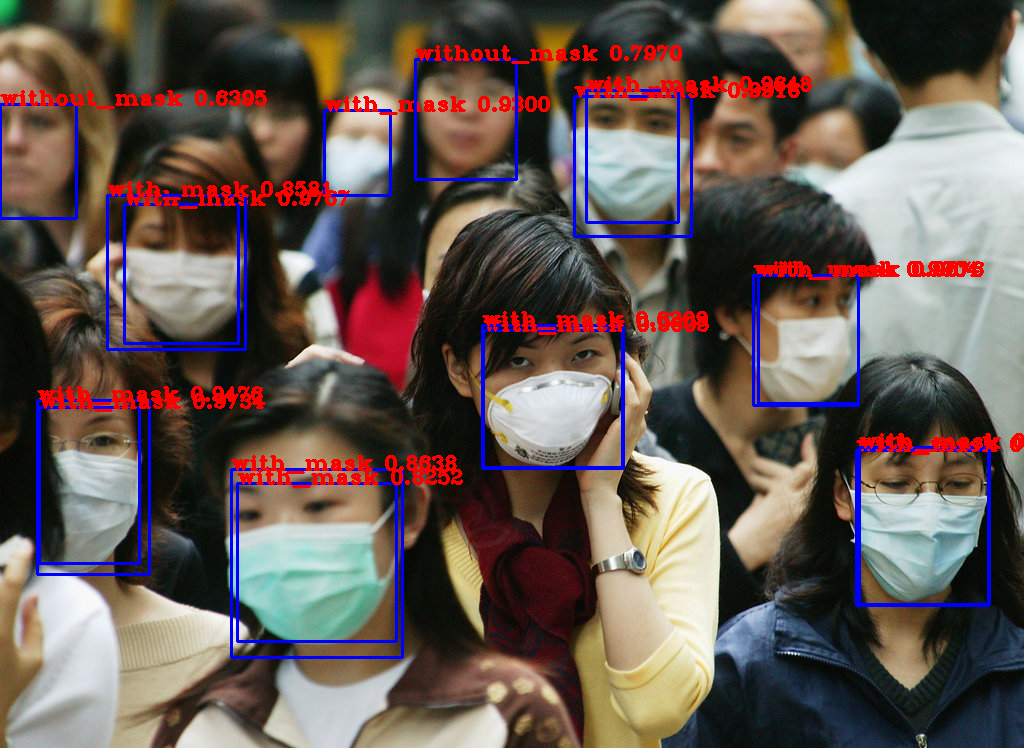

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)